# Soft Actor Critic with recurrent policy network

The SAC with recurrent policy network is shows to stabilize the 1-d particle in a noicy linear system with full observability. The end shows a comparison to the (optimal) LQR.

Next up: show how the same particle is controlled under noicy (and later) partial observations.
> comparison to LQG

In [1]:
import jax
import jax.numpy as jnp
import jax.random as jrandom

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
plt.style.use('ggplot')

# import local libraries
from environments.linear import Linear_SDI
from src.SAC_FP.run import run_SAC
from src.SAC_FP.utilities.replay_buffer import ReplayBuffer
from src.SAC_FP.utilities.preprocessing import normalize
from src.SAC_FP.init import *

from src.OptimalControl.LQR import LQRSolver


## Initialize

In [2]:
"""Parameters"""
key = jrandom.PRNGKey(0)
gamma = .99
history_size = 12

control_scale = 4
state_scale = 5

batch_size = 128
policy_update_freq = 2
epochs_per_step = 10
buffer_size = 10000

# learning rates
lr = 2e-4
lr_v = lr
lr_q = lr
lr_pi = lr
lr_alpha = lr

"""Initialization"""
keys = jrandom.split(key, 4)
#pi = pi_init(2, 1, lr_pi, keys[0])
pi = pi_rnn_init(3, 1, lr_pi, keys[0])
vf = vf_init(2, 1, 32, 2, lr_v, keys[1])
vf_target = vf_init(2, 1, 32, 2, lr_v, keys[1])[0]
qf1 = qf_init(3, 1, 32, 2, lr_q, keys[2])
qf2 = qf_init(3, 1, 32, 2, lr_q, keys[3])
af = alpha_init(lr_alpha)

params = (pi, qf1, qf2, vf, vf_target, af)

"""Environment"""
env = Linear_SDI(end_time=20)
env.v = jnp.zeros((2,2))
env.boundary = True
env.min = -jnp.ones(2) * state_scale
env.max = jnp.ones(2) * state_scale

"""Normalization"""
reward_scale = (state_scale**2 + control_scale**2) * env.dt

"""Replay Buffer"""
buffer = ReplayBuffer(buffer_size, 2, key, history_size=history_size)


## Train

In [3]:
n_steps = 1200
params, env, buffer = run_SAC(
    params,
    env,
    buffer,
    n_steps,
    batch_size,
    key,
    online=True,

    gamma=gamma,
    control_scale=control_scale,
    state_scale=state_scale,
    policy_update_freq=policy_update_freq,
    epochs_per_step=epochs_per_step,
)

pi, qf1, qf2, vf, vf_target, af = params

step=  150	pi=9.21812	q=10.90125	v=85.36819	alpha=-8.10721
step=  150	pi=9.11110	q=10.81053	v=83.59677	alpha=-8.00000
step=  150	pi=9.09833	q=10.81592	v=83.31720	alpha=-7.98711
step=  150	pi=9.19295	q=10.84150	v=84.82323	alpha=-8.08171
step=  150	pi=9.26446	q=10.66450	v=86.12508	alpha=-8.15311
step=  150	pi=9.05960	q=10.77073	v=82.75377	alpha=-7.94798
step=  150	pi=9.16737	q=10.77678	v=84.42582	alpha=-8.05571
step=  150	pi=9.19081	q=10.14500	v=84.87013	alpha=-8.07883
step=  150	pi=9.06826	q=10.58622	v=82.71504	alpha=-7.95617
step=  150	pi=9.09186	q=10.54478	v=83.20786	alpha=-7.97974
step=  151	pi=0.00000	q=10.65532	v=80.48065	alpha=-7.82918
step=  151	pi=0.00000	q=10.07994	v=81.54770	alpha=-7.88975
step=  151	pi=0.00000	q=10.27893	v=82.50541	alpha=-7.93923
step=  151	pi=0.00000	q=10.62103	v=82.17018	alpha=-7.92314
step=  151	pi=0.00000	q=9.51495	v=83.24882	alpha=-7.97764
step=  151	pi=0.00000	q=10.56145	v=84.01036	alpha=-8.02570
step=  151	pi=0.00000	q=10.51740	v=82.87465	alpha=-7.9591

## Test

### Network surface plots

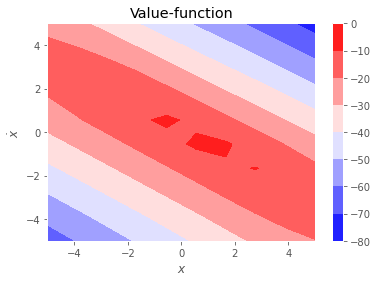

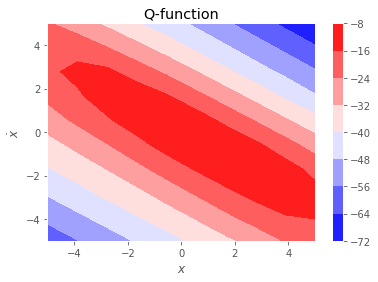

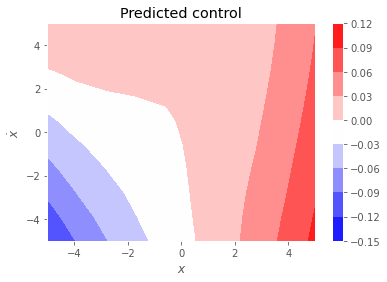

In [4]:
N = 10

x_space = np.linspace(-5, 5, N)
v_space = np.linspace(-5, 5, N)
#u_space = np.linspace(-control_scale, control_scale, N)

xv, vv = np.meshgrid(x_space, v_space)

V = np.zeros((N, N))
Q = np.zeros((N, N))
U = np.zeros((N, N))

v_fn, v_opt, v_state = vf
vt_fn = vf_target
q1_fn, q1_opt, q1_state = qf1
q2_fn, q2_opt, q2_state = qf2
pi_fn, pi_opt, pi_state = pi


for i, x in enumerate(x_space):
    for j, v in enumerate(v_space):
        state = normalize(jnp.array([x, v]), state_scale)
        control = 0
        V[i, j] = v_fn(state)
        q1 = q1_fn(state, control)
        q2 = q2_fn(state, control)
        Q[i, j] = jax.lax.min(q1, q2)
        U[i, j], _ = pi_fn.predict_step(state, 0, state)


fig, ax = plt.subplots()
plt.contourf(xv, vv, V, cmap=cm.bwr)
plt.colorbar()
plt.xlabel(r'$x$')
plt.ylabel(r'$\dot{x}$')
plt.title('Value-function')
plt.show()

fig, ax = plt.subplots()
plt.contourf(xv, vv, Q, cmap=cm.bwr)
plt.colorbar()
plt.xlabel(r'$x$')
plt.ylabel(r'$\dot{x}$')
plt.title('Q-function')
plt.show()

fig, ax = plt.subplots()
plt.contourf(xv, vv, U, cmap=cm.bwr)
plt.colorbar()
plt.xlabel(r'$x$')
plt.ylabel(r'$\dot{x}$')
plt.title('Predicted control')
plt.show()


In [5]:
N = 10

x_space = np.linspace(-5, 5, N)
v_space = np.linspace(-5, 5, N)
u_space = np.linspace(-control_scale, control_scale, N)

xv, vv = np.meshgrid(x_space, v_space)

V = np.zeros((N, N))
Q = np.zeros((N, N, N))
U = np.zeros((N, N))

v_fn, v_opt, v_state = vf
vt_fn = vf_target
q1_fn, q1_opt, q1_state = qf1
q2_fn, q2_opt, q2_state = qf2
pi_fn, pi_opt, pi_state = pi


for i, x in enumerate(x_space):
    for j, v in enumerate(v_space):
        for k, u in enumerate(u_space):
            state = normalize(jnp.array([x, v]), state_scale)
            u = normalize(u, control_scale)
            q1 = q1_fn(state, u)
            q2 = q2_fn(state, u)
            Q[i, j, k] = jax.lax.min(q1, q2)


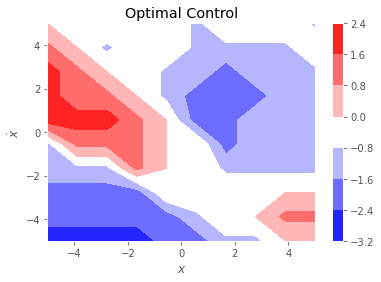

In [6]:
C = jnp.argmax(Q, axis=2) - 5

fig, ax = plt.subplots()
plt.contourf(xv, vv, C, cmap=cm.bwr)
plt.colorbar()
plt.xlabel(r'$x$')
plt.ylabel(r'$\dot{x}$')
plt.title('Optimal Control')
plt.show()


### Run test trial

In [7]:
def run(
    key,
    env,
    controller,
    T,
    x0 = None,
    n_obs = 2
):
    t_space = np.arange(0, T, env.dt)

    Y = np.zeros((len(t_space), n_obs))
    S = np.zeros((len(t_space), n_obs))

    y = env.reset(x0)
    for idx, t in enumerate(np.arange(0, T, env.dt)):
        u = controller(y)
        y, rew, done, _ = env.step(u, key=key)
        Y[idx] = y
        S[idx] = env.state

        key, _ = jrandom.split(key)
    
    return S, Y


def run_recurrent(
    key,
    env,
    policy,
    T,
    x0 = None,
    n_obs = 2
):
    t_space = np.arange(0, T, env.dt)

    Y = np.zeros((len(t_space), n_obs))
    S = np.zeros((len(t_space), n_obs))

    y = env.reset(x0)
    u = 0
    hidden = y
    for idx, t in enumerate(np.arange(0, T, env.dt)):
        u, hidden = policy.predict_step(normalize(y, state_scale), u, hidden)
        y, rew, done, _ = env.step(u * control_scale)
        Y[idx] = y
        S[idx] = env.state
    
    return S, Y


(-4.0, 4.0)

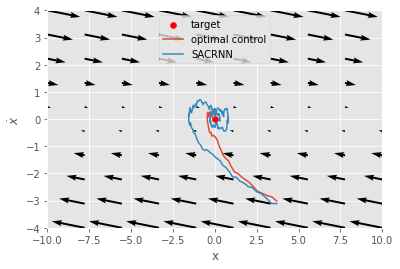

In [8]:
N = 10

x_space = np.linspace(-10, 10, N)
v_space = np.linspace(-4, 4, N)
xv, vv = np.meshgrid(x_space, v_space)
qx = np.zeros((N,N))
qv = np.zeros((N,N))

for i, x in enumerate(x_space):
  for j, v in enumerate(v_space):
    state = jnp.array([xv[i,j], vv[i,j]])
    norm_state = normalize(state, state_scale)
    #control, _ = pi_fn.predict_step(norm_state, 0, norm_state)
    control = 0
    dx, dv = env.predict_deriv(state, control * control_scale)
    qx[i,j] = dx
    qv[i,j] = dv


x0 = jnp.array([4, -3])
# key, _ = jrandom.split(key)
# x0 = jrandom.uniform(key, (2,), minval=-4, maxval=4)

fig, ax = plt.subplots()

# Optimal point (target)
ax.scatter(0, 0, c='r', label='target')

# optimal control trajectory (LQR)
LQR = LQRSolver(env.A, env.B, env.G, env.R)
S, Y = run(key, env, LQR, 5, x0=x0)
ax.plot(S[:,0], S[:,1], label='optimal control')

# Recurrent SAC trajectory
S, Y = run_recurrent(key, env, pi_fn, 20, x0=x0)
ax.plot(S[:,0], S[:,1], label='SACRNN')

ax.quiver(xv, vv, qx, qv)
ax.legend()
ax.set_xlabel('x')
ax.set_ylabel(r'$\dot{x}$')
ax.set_xlim([-10, 10])
ax.set_ylim([-4, 4])